# Collation with decision graph and without pandas

Revision based on consultation on *decision-graph-2.ipynb*

w1 patterns are on top, w2 on left

Order the patterns (shared ngrams of any length) on:

1. Coordinate witness A ascending, then
1. Coordinate witness B ascending, then
1. Length of the pattern from large to small (descending).

Patterns have the shape (A:int, B:int, ngram:str)

The first part of this notebook, through the identification of shared ngrams, is copied from our earlier efforts.

## Data

There will always be a single root (because we create one!) and exactly one or two leaves:

1. One leaf: If the last shared pattern is the last shared pattern in both witnesses, there is a single leaf
1. Two leaves: If the last shared pattern in one witness is not the last shared pattern in the other, and vice versa, there are two leaves

In [1]:
# two witnesses, with repetition and transposition

# Original example, single leaf node
w1 = '''the red and the black cat'''
w2 = '''the black and the red cat'''

# Adjacent transposition
# w1 = '''the red striped cat'''
# w2 = '''the striped red cat'''

# Two leaf nodes
# w1 = '''cat red black'''
# w2 = '''cat black red'''

# Branches meet in the middle at koala and then split again, with two leaf nodes
# w1 = """cat red black koala brown gray"""
# w2 = """cat black red koala gray brown"""

# Two split and rejoin
# w1 = '''the gray koala'''
# w2 = '''the brown koala'''

# medium example
# w1 = '''WHEN we look to the individuals of the same variety or sub-variety of
# our older cultivated plants and animals, one of the first points which strikes us, is,
# that they generally differ much more from each other, than do the individuals of any one
# species or variety in a state of nature.'''
# w2 = '''WHEN we look to the individuals of the same variety or sub-variety of
# our older cultivated plants and animals, one of the first points which strikes us, is,
# that they generally differ more from each other than do the individuals of any one
# species or variety in a state of nature.'''

# Larger example
# w1 = '''WHEN we look to the individuals of the same variety or sub-variety of
# our older cultivated plants and animals, one of the first points which strikes us, is,
# that they generally differ much more from each other, than do the individuals of any one
# species or variety in a state of nature. When we reflect on the vast diversity of the
# plants and animals which have been cultivated, and which have varied during all ages
# under the most different climates and treatment, I think we are driven to conclude that
# this greater variability is simply due to our domestic productions having been raised
# under conditions of life not so uniform as, and somewhat different from, those to which
# the parent-species have been exposed under nature. There is, also, I think, some
# probability in the view propounded by Andrew Knight, that this variability may be partly
# connected with excess of food. It seems pretty clear that organic beings must be exposed
# during several generations to the new conditions of life to cause any appreciable amount
# of variation; and that when the organisation has once begun to vary, it generally
# continues to vary for many generations. No case is on record of a variable being ceasing
# to be variable under cultivation. Our oldest cultivated plants, such as wheat, still
# often yield new varieties: our oldest domesticated animals are still capable of rapid
# improvement or modification.'''
# w2 = '''WHEN we look to the individuals of the same variety or sub-variety of
# our older cultivated plants and animals, one of the first points which strikes us, is,
# that they generally differ more from each other than do the individuals of any one
# species or variety in a state of nature. When we reflect on the vast diversity of the
# plants and animals which have been cultivated, and which have varied during all ages
# under the most different climates and treatment, I think we are driven to conclude that
# this great variability is simply due to our domestic productions having been raised
# under conditions of life not so uniform as, and somewhat different from, those to which
# the parent-species have been exposed under nature. There is also, I think, some
# probability in the view propounded by Andrew Knight, that this variability may be partly
# connected with excess of food. It seems pretty clear that organic beings must be exposed
# during several generations to the new conditions of life to cause any appreciable amount
# of variation; and that when the organisation has once begun to vary, it generally
# continues to vary for many generations. No case is on record of a variable being ceasing
# to be variable under cultivation. Our oldest cultivated plants, such as wheat, still
# often yield new varieties: our oldest domesticated animals are still capable of rapid
# improvement or modification'''

## Construct list of ngrams shared by witnesses

Find ngrams and positions in witnesses

### Tokenize witnesses

In [2]:
def tokenize_witnesses(w1_string, w2_string):
    '''Return list of witnesses, each represented by a list of tokens'''
    # TODO: handle punctuation, upper- ~ lowercase
    w1_tokens = w1.split()
    w2_tokens = w2.split()
    witnesses = [w1_tokens, w2_tokens]
    return witnesses

In [3]:
witnesses = tokenize_witnesses(w1, w2)
print(witnesses) # take a look

[['the', 'red', 'and', 'the', 'black', 'cat'], ['the', 'black', 'and', 'the', 'red', 'cat']]


### Find ngrams shared by the witnesses

In [4]:
from collections import defaultdict

def compute_ngrams_all(witness):
    '''Create n-grams and returns offsets and lengths

    Argument:
    witness:list -- list of tokens in witness

    Returns:
    ngrams:dict --       key is ngram
                         value is list of start positions in witness for ngram
    token_counts:dict -- key is ngram
                         value is token count of ngram
    '''
    ngram_offsets = defaultdict(list)
    token_counts = {}
    for n in range(1, len(witness) + 1):
        for i in range(len(witness)-n+1):
            g = ' '.join(witness[i:i+n]) # store each ngram as g temporarily
            ngram_offsets[g].append(i)
            token_counts[g] = n
    return ngram_offsets, token_counts

In [5]:
ngram_offsets_by_witness_dict = {} # keyed by witness
ngram_lengths = {}
for index, witness in enumerate(witnesses):
    map1, map2 = compute_ngrams_all(witness)
    ngram_offsets_by_witness_dict['w' + str(index + 1)] = map1
    ngram_lengths.update(map2)

In [6]:
# Look at ngram lists for each witness
# Keys of inner dictionary are ngrams, values are lists of start positions in witness
for key in ngram_offsets_by_witness_dict.keys():
    print('Witness ' + key)
    print(ngram_offsets_by_witness_dict[key])
    print()

Witness w1
defaultdict(<class 'list'>, {'the': [0, 3], 'red': [1], 'and': [2], 'black': [4], 'cat': [5], 'the red': [0], 'red and': [1], 'and the': [2], 'the black': [3], 'black cat': [4], 'the red and': [0], 'red and the': [1], 'and the black': [2], 'the black cat': [3], 'the red and the': [0], 'red and the black': [1], 'and the black cat': [2], 'the red and the black': [0], 'red and the black cat': [1], 'the red and the black cat': [0]})

Witness w2
defaultdict(<class 'list'>, {'the': [0, 3], 'black': [1], 'and': [2], 'red': [4], 'cat': [5], 'the black': [0], 'black and': [1], 'and the': [2], 'the red': [3], 'red cat': [4], 'the black and': [0], 'black and the': [1], 'and the red': [2], 'the red cat': [3], 'the black and the': [0], 'black and the red': [1], 'and the red cat': [2], 'the black and the red': [0], 'black and the red cat': [1], 'the black and the red cat': [0]})



In [7]:
# Look at ngram lengths (combined)
print(ngram_lengths)

{'the': 1, 'red': 1, 'and': 1, 'black': 1, 'cat': 1, 'the red': 2, 'red and': 2, 'and the': 2, 'the black': 2, 'black cat': 2, 'the red and': 3, 'red and the': 3, 'and the black': 3, 'the black cat': 3, 'the red and the': 4, 'red and the black': 4, 'and the black cat': 4, 'the red and the black': 5, 'red and the black cat': 5, 'the red and the black cat': 6, 'black and': 2, 'red cat': 2, 'the black and': 3, 'black and the': 3, 'and the red': 3, 'the red cat': 3, 'the black and the': 4, 'black and the red': 4, 'and the red cat': 4, 'the black and the red': 5, 'black and the red cat': 5, 'the black and the red cat': 6}


In [8]:
# find keys shared by *all* witnesses
shared_ngrams = set(ngram_offsets_by_witness_dict["w1"].keys())
for value in ngram_offsets_by_witness_dict.values():
    shared_ngrams = shared_ngrams.intersection(value.keys())

shared_ngrams # take a look

{'and', 'and the', 'black', 'cat', 'red', 'the', 'the black', 'the red'}

### Use shared ngrams to find potential alignments

In [9]:
# output format: {ngram : [(0,1), (2,3)]}, where
#   the two entries in each tuple are for witnesses A and B
potential_alignments = defaultdict(list)
for ngram in shared_ngrams:
    for w1_offset in ngram_offsets_by_witness_dict['w1'][ngram]:
        for w2_offset in ngram_offsets_by_witness_dict['w2'][ngram]:
            potential_alignments[ngram].append((w1_offset, w2_offset))

print(potential_alignments)

defaultdict(<class 'list'>, {'and the': [(2, 2)], 'red': [(1, 4)], 'and': [(2, 2)], 'the red': [(0, 3)], 'cat': [(5, 5)], 'the': [(0, 0), (0, 3), (3, 0), (3, 3)], 'the black': [(3, 0)], 'black': [(4, 1)]})


### Invert keys and values for potential alignments

* Keys are now individual tuples of (A, B) start positions
* Values are now lists of ngrams of different lengths at those positions

In [10]:
alignments = defaultdict(list)
for key,value in potential_alignments.items():
    for t in value:
        alignments[t].append(key)

print(alignments)

defaultdict(<class 'list'>, {(2, 2): ['and the', 'and'], (1, 4): ['red'], (0, 3): ['the red', 'the'], (5, 5): ['cat'], (0, 0): ['the'], (3, 0): ['the', 'the black'], (3, 3): ['the'], (4, 1): ['black']})


In [11]:
# https://docs.python.org/3/library/dataclasses.html
from dataclasses import dataclass

In [12]:
@dataclass(unsafe_hash=True)
class Pattern:
    __slots__ = ['token_start_position_A', 'token_start_position_B', 'ngram', 'ngram_length', 'token_end_position_A', 'token_end_position_B']
    token_start_position_A: int
    token_start_position_B: int
    ngram: str
    ngram_length: int
    token_end_position_A: int
    token_end_position_B: int

In [13]:
# column labels, ordered by w1 pos, then w2 pos, then ngram length (long to short)
patterns_A = [] # will need to be sorted after all values have been added
for k, v in alignments.items():
    for ngram in v: # add instance of dataclass Pattern for each ngram at A,B positions
        current_ngram_length = ngram_lengths[ngram]
        patterns_A.append(Pattern(k[0], k[1], ngram, current_ngram_length, k[0] + current_ngram_length - 1, k[1] + current_ngram_length - 1))
patterns_A = sorted(patterns_A, key=lambda x: (x.token_start_position_A, x.token_start_position_B, -x.ngram_length))
patterns_A.insert(0, Pattern(-1, -1, 'ROOT', 1, -1, -1))
patterns_A # take a look

[Pattern(token_start_position_A=-1, token_start_position_B=-1, ngram='ROOT', ngram_length=1, token_end_position_A=-1, token_end_position_B=-1),
 Pattern(token_start_position_A=0, token_start_position_B=0, ngram='the', ngram_length=1, token_end_position_A=0, token_end_position_B=0),
 Pattern(token_start_position_A=0, token_start_position_B=3, ngram='the red', ngram_length=2, token_end_position_A=1, token_end_position_B=4),
 Pattern(token_start_position_A=0, token_start_position_B=3, ngram='the', ngram_length=1, token_end_position_A=0, token_end_position_B=3),
 Pattern(token_start_position_A=1, token_start_position_B=4, ngram='red', ngram_length=1, token_end_position_A=1, token_end_position_B=4),
 Pattern(token_start_position_A=2, token_start_position_B=2, ngram='and the', ngram_length=2, token_end_position_A=3, token_end_position_B=3),
 Pattern(token_start_position_A=2, token_start_position_B=2, ngram='and', ngram_length=1, token_end_position_A=2, token_end_position_B=2),
 Pattern(token

In [14]:
patterns_B = sorted(patterns_A, key=lambda x: (x.token_start_position_B, x.token_start_position_A, -x.ngram_length))
patterns_B # take a look

[Pattern(token_start_position_A=-1, token_start_position_B=-1, ngram='ROOT', ngram_length=1, token_end_position_A=-1, token_end_position_B=-1),
 Pattern(token_start_position_A=0, token_start_position_B=0, ngram='the', ngram_length=1, token_end_position_A=0, token_end_position_B=0),
 Pattern(token_start_position_A=3, token_start_position_B=0, ngram='the black', ngram_length=2, token_end_position_A=4, token_end_position_B=1),
 Pattern(token_start_position_A=3, token_start_position_B=0, ngram='the', ngram_length=1, token_end_position_A=3, token_end_position_B=0),
 Pattern(token_start_position_A=4, token_start_position_B=1, ngram='black', ngram_length=1, token_end_position_A=4, token_end_position_B=1),
 Pattern(token_start_position_A=2, token_start_position_B=2, ngram='and the', ngram_length=2, token_end_position_A=3, token_end_position_B=3),
 Pattern(token_start_position_A=2, token_start_position_B=2, ngram='and', ngram_length=1, token_end_position_A=2, token_end_position_B=2),
 Pattern(t

In [15]:
# Node objects contain unique id values plus pattern (not token) coordinates for both witnesses
@dataclass(unsafe_hash=True)
class Node:
    __slots__ = ['id', 'pattern_coordinate_witness_A', 'pattern_coordinate_witness_B']
    id: int
    pattern_coordinate_witness_A: int # offset into list of patterns (not the same as token coordinate)
    pattern_coordinate_witness_B: int
    # score: int # count of aligned tokens, or should that be on the edges?

In [16]:
# Dictionary to check whether node has already been added for a pattern:
#
# If the node has already been added, don't add a new node, but retrieve the node id to add a new edge
# If the node has not already been added, add it, along with an edge

node_finder = {} #dictionary; key is pattern coordinate A, value is node id

In [17]:
# First create root node
root = Node(0, 0, 0)
node_finder[0] = 0

In [18]:
# Configure to show multiple value for development and debugging
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [19]:
root # take a look
node_finder

Node(id=0, pattern_coordinate_witness_A=0, pattern_coordinate_witness_B=0)

{0: 0}

In [20]:
# find and save all diagonal patterns in list
# TODO: can we use a copy constructor to avoid having to copy all of the properties individually?
diagonal_patterns = []
for table_offset_A, pattern in enumerate(patterns_A): # find table offset for each A pattern
    if patterns_B[table_offset_A] is pattern: # is the pattern at the same offset in B the same object?
        diagonal_patterns.append(pattern) # if so, it's a diagonal
diagonal_patterns # take a look

[Pattern(token_start_position_A=-1, token_start_position_B=-1, ngram='ROOT', ngram_length=1, token_end_position_A=-1, token_end_position_B=-1),
 Pattern(token_start_position_A=0, token_start_position_B=0, ngram='the', ngram_length=1, token_end_position_A=0, token_end_position_B=0),
 Pattern(token_start_position_A=2, token_start_position_B=2, ngram='and the', ngram_length=2, token_end_position_A=3, token_end_position_B=3),
 Pattern(token_start_position_A=2, token_start_position_B=2, ngram='and', ngram_length=1, token_end_position_A=2, token_end_position_B=2),
 Pattern(token_start_position_A=3, token_start_position_B=3, ngram='the', ngram_length=1, token_end_position_A=3, token_end_position_B=3),
 Pattern(token_start_position_A=5, token_start_position_B=5, ngram='cat', ngram_length=1, token_end_position_A=5, token_end_position_B=5)]

In [21]:
def find_diagonal_pattern_for_node(current_node : Node):
    # go over the diagional patterns and find the first pattern that begins after the end token of the current pattern.
    current_pattern_A = patterns_A[current_node.pattern_coordinate_witness_A] # offset into list of patterns
    current_pattern_B = patterns_B[current_node.pattern_coordinate_witness_B]

    next_diagonal_pattern = next(filter(lambda dp: dp.token_start_position_A > current_pattern_A.token_end_position_A and dp.token_start_position_B > current_pattern_B.token_end_position_B, diagonal_patterns), None)
    return next_diagonal_pattern

next_pattern_in_both = find_diagonal_pattern_for_node(root)
next_pattern_in_both

Pattern(token_start_position_A=0, token_start_position_B=0, ngram='the', ngram_length=1, token_end_position_A=0, token_end_position_B=0)

## Step 1: Create graph and add root node

In [22]:
from typing import Set

@dataclass(unsafe_hash=True)
class Edge:
    __slots__ = ['source', 'target']
    source: int
    target: int

@dataclass
class Graph: # set of nodes (TODO: also set of edges)
    __slots__ = ['nodes', 'edges']
    nodes: Set[Node]
    edges: Set[Edge]

nodes = {root} # set of nodes
edges = set()
graph = Graph(nodes, edges)
graph # take a look; so far just one node (root) and no edges

Graph(nodes={Node(id=0, pattern_coordinate_witness_A=0, pattern_coordinate_witness_B=0)}, edges=set())

## Steps 2–4, 6: Add children of root node recursively, with edges

In [23]:
# stable lookup for index position of pattern in witness-specific lists of patterns
patterns_A_position_by_value = {val: index for index, val in enumerate(patterns_A)} # retrieve offset in witness-specific list of patterns by pattern
patterns_B_position_by_value = {val: index for index, val in enumerate(patterns_B)} # retrieve offset in witness-specific list of patterns by pattern

In [24]:
# Recursive function to add all nodes to graph in depth-first-order
# Starts from root, with has already been added manually
from typing import List
# Ror each node we create at most three children plus edges (or just edges if a child node already exists):
#
#   1. Next pattern in Witness A. Look for the same pattern in Witness B. Should not be a diagional, see below.
#   2. Next pattern in Witness B. Look for the same pattern in Witness A. Should not be a diagional, see below.
#   3. Next pattern on a diagional. Could result in a skip of the patterns mentioned above.

# function to identify and add all children of specified node
# TODO: do not create child if it already exists
def add_children(parent: Node): # find and create children of input (parent), returns nothing
    # BUG: we currently exclude diagonals from closest in A and B incorrectly; diagonals are from the parent at each step, and not invariably from the root
    # find closest in A and B that are not also diagonals and create node plus edge (or just edge, if node has already been added)
    # find closest diagonal and create node (or just edge, if node has already been added)
    pattern_A = patterns_A[parent.pattern_coordinate_witness_A] # offset of parent Pattern in list of patterns ordered by witness A
    token_coordinate_witness_A = pattern_A.token_end_position_A # ending token position of parent in witness A
    token_coordinate_witness_B = pattern_A.token_end_position_B
    next_A_pattern = next(filter(lambda x : x.token_start_position_A > token_coordinate_witness_A and x.token_start_position_B > token_coordinate_witness_B \
                               and x not in diagonal_patterns, patterns_A[parent.pattern_coordinate_witness_A:]), None) # first pattern after parent token position
    next_B_pattern = next(filter(lambda x : x.token_start_position_A > token_coordinate_witness_A and x.token_start_position_B > token_coordinate_witness_B \
                               and x not in diagonal_patterns, patterns_B[parent.pattern_coordinate_witness_B:]), None) # first pattern after parent token position
    next_diag_pattern = find_diagonal_pattern_for_node(parent)

    if next_A_pattern:
        next_A_pattern_index_A = patterns_A_position_by_value[next_A_pattern]
        next_A_pattern_index_B = patterns_B_position_by_value[next_A_pattern]

        if not next_A_pattern_index_A in node_finder: # add new node only if it hasn't already been added
            new_node_id = len(graph.nodes)
            first_node = Node(new_node_id, next_A_pattern_index_A, next_A_pattern_index_B) # create new node
            nodes.add(first_node)
            node_finder[next_A_pattern_index_A] = new_node_id # and update node finder
            edge1 = Edge(parent.id, first_node.id) # add edge to newly created node
            edges.add(edge1)
            add_children(first_node)
        else:
            edge1 = Edge(parent.id, node_finder[next_A_pattern_index_A]) # add new edge to pre-existing node
            edges.add(edge1)

    if next_B_pattern:
        next_B_pattern_index_A = patterns_A_position_by_value[next_B_pattern]
        next_B_pattern_index_B = patterns_B_position_by_value[next_B_pattern]

        if not next_B_pattern_index_A in node_finder:
            new_node_id = len(graph.nodes)
            second_node = Node(new_node_id, next_B_pattern_index_A, next_B_pattern_index_B)
            nodes.add(second_node)
            node_finder[next_B_pattern_index_A] = new_node_id
            edge2 = Edge(parent.id, second_node.id)
            edges.add(edge2)
            add_children(second_node)
        else:
            edge2 = Edge(parent.id, node_finder[next_B_pattern_index_A])
            edges.add(edge2)

    if next_diag_pattern:
        next_diag_pattern_index_A = patterns_A_position_by_value[next_diag_pattern]
        next_diag_pattern_index_B = patterns_B_position_by_value[next_diag_pattern]

        if not next_diag_pattern_index_A in node_finder:
            new_node_id = len(graph.nodes)
            third_node = Node(new_node_id, next_diag_pattern_index_A, next_diag_pattern_index_B)
            nodes.add(third_node)
            node_finder[next_diag_pattern_index_A] = new_node_id
            edge3 = Edge(parent.id, third_node.id)
            edges.add(edge3)
            add_children(third_node)
        else:
            edge3 = Edge(parent.id, node_finder[next_diag_pattern_index_A])
            edges.add(edge3)

In [25]:
# Populate the graph (all nodes and edges)
add_children(root)

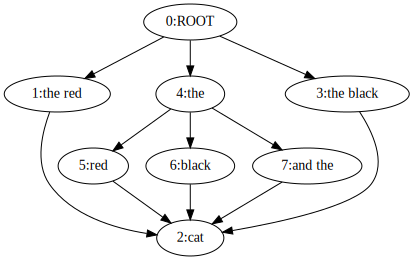

In [26]:
# get ready to visualize the decision tree in SVG
import graphviz
from IPython.display import SVG

# node id values must be strings for graphviz
a = graphviz.Digraph(format="svg")
for item in graph.nodes: # set of Node objects, call it "item" to avoid overusing the keyword "node"
    a.node(str(item.id), label=str(item.id) + ':' + patterns_A[item.pattern_coordinate_witness_A].ngram)
for item in graph.edges:
    a.edge(str(item.source), str(item.target))
SVG(a.view())

In [27]:
graph.nodes
graph.edges

{Node(id=0, pattern_coordinate_witness_A=0, pattern_coordinate_witness_B=0),
 Node(id=1, pattern_coordinate_witness_A=2, pattern_coordinate_witness_B=7),
 Node(id=2, pattern_coordinate_witness_A=11, pattern_coordinate_witness_B=11),
 Node(id=3, pattern_coordinate_witness_A=7, pattern_coordinate_witness_B=2),
 Node(id=4, pattern_coordinate_witness_A=1, pattern_coordinate_witness_B=1),
 Node(id=5, pattern_coordinate_witness_A=4, pattern_coordinate_witness_B=10),
 Node(id=6, pattern_coordinate_witness_A=10, pattern_coordinate_witness_B=4),
 Node(id=7, pattern_coordinate_witness_A=5, pattern_coordinate_witness_B=5)}

{Edge(source=0, target=1),
 Edge(source=0, target=3),
 Edge(source=0, target=4),
 Edge(source=1, target=2),
 Edge(source=3, target=2),
 Edge(source=4, target=5),
 Edge(source=4, target=6),
 Edge(source=4, target=7),
 Edge(source=5, target=2),
 Edge(source=6, target=2),
 Edge(source=7, target=2)}

### Non-OO Python implementation of Kahn's topological sort algorithm

https://algocoding.wordpress.com/2015/04/05/topological-sorting-python/

In [28]:
# convert set of edges to adjacency list, preparatory to topological sorting
adjacency_list = defaultdict(list) # key is source, value is list of targets
for edge in graph.edges:
    adjacency_list[edge.source].append(edge.target)
    if edge.target not in adjacency_list: # adjacency list needs a key for every node, even if 
        adjacency_list[edge.target] = []
adjacency_list # take a look

defaultdict(list,
            {0: [1, 4, 3],
             1: [2],
             6: [2],
             2: [],
             4: [6, 5, 7],
             3: [2],
             5: [2],
             7: [2]})

In [29]:
# copied from https://algocoding.wordpress.com/2015/04/05/topological-sorting-python/

from collections import deque

def kahn_topsort(graph):
    in_degree = { u : 0 for u in graph }     # determine in-degree
    for u in graph:                          # of each node
        for v in graph[u]:
            in_degree[v] += 1

    Q = deque()                 # collect nodes with zero in-degree
    for u in in_degree:
        if in_degree[u] == 0:
            Q.appendleft(u)

    L = []     # list for order of nodes

    while Q:
        u = Q.pop()          # choose node of zero in-degree
        L.append(u)          # and 'remove' it from graph
        for v in graph[u]:
            in_degree[v] -= 1
            if in_degree[v] == 0:
                Q.appendleft(v)

    if len(L) == len(graph):
        return L
    else:                    # if there is a cycle,
        return []            # then return an empty list

In [30]:
order = kahn_topsort(adjacency_list)

In [31]:
print(order)

[0, 1, 4, 3, 6, 5, 7, 2]


In [32]:
# dictionary to retrieve parent by child
parent_by_child = defaultdict(list)
for k, v in adjacency_list.items():
    for node in v:
        parent_by_child[node].append(k)
parent_by_child # take a look

defaultdict(list,
            {1: [0],
             4: [0],
             3: [0],
             2: [1, 6, 3, 5, 7],
             6: [4],
             5: [4],
             7: [4]})

In [33]:
# traverse in topological order to find best path
# for each node, track cumulative score (token score plus best token count of parents) and best parent
# may be ties for best score / parent

from typing import List

@dataclass
class Score:
    __slots__ = ['total', 'parent']
    total: int # best cumulative total
    parent: List[int] # node id

scores = {}
scores[0] = Score(total = 0, parent = []) # add root manually

scores # take a look

{0: Score(total=0, parent=[])}

In [34]:
# Sigh ... another dictionary!
node_by_id = {}
for node in graph.nodes:
    node_by_id[node.id] = node
node_by_id # take a look

{1: Node(id=1, pattern_coordinate_witness_A=2, pattern_coordinate_witness_B=7),
 0: Node(id=0, pattern_coordinate_witness_A=0, pattern_coordinate_witness_B=0),
 4: Node(id=4, pattern_coordinate_witness_A=1, pattern_coordinate_witness_B=1),
 2: Node(id=2, pattern_coordinate_witness_A=11, pattern_coordinate_witness_B=11),
 5: Node(id=5, pattern_coordinate_witness_A=4, pattern_coordinate_witness_B=10),
 3: Node(id=3, pattern_coordinate_witness_A=7, pattern_coordinate_witness_B=2),
 6: Node(id=6, pattern_coordinate_witness_A=10, pattern_coordinate_witness_B=4),
 7: Node(id=7, pattern_coordinate_witness_A=5, pattern_coordinate_witness_B=5)}

In [35]:
# score all nodes, keep track of best cumulative score
best_score = 0 # best cumulative score for all nodes
for node in order[1:]: # skip root; already done
    local_ngram_count = patterns_A[node_by_id[node].pattern_coordinate_witness_A].ngram_length # ngram token count for current node
    parents = parent_by_child[node] # all parents
    best_parent_score = 0
    best_parents = [] # parents with highest score
    for parent in parents:
        current_parent_score = scores[parent].total
        if current_parent_score > best_parent_score: # replace old best score and parent pointers
            best_parent_score = current_parent_score
            best_parents = [parent]
        elif current_parent_score == best_parent_score: # tie for best parent, so add to list
            best_parents.append(parent)
    scores[node] = Score(total = best_parent_score + local_ngram_count, parent = best_parents)
    if scores[node].total > best_score: # if new score is highest of all so far, update best_score
        best_score = scores[node].total
scores # take a look at all scores,
best_score # and at best score

{0: Score(total=0, parent=[]),
 1: Score(total=2, parent=[0]),
 4: Score(total=1, parent=[0]),
 3: Score(total=2, parent=[0]),
 6: Score(total=2, parent=[4]),
 5: Score(total=2, parent=[4]),
 7: Score(total=3, parent=[4]),
 2: Score(total=4, parent=[7])}

4

In [36]:
# there will be exactly one or exactly two best leaves, return as list
best_leaves = [k for k,v in scores.items() if v.total == best_score] # id(s) of leaves with best cumulative score
best_leaves # take a look at leaves with best score

[2]

# Work plan

1. Traverse backward from best leaf (choose one) to find best path (choose one)
1. Build and render variant graph (no transpositions yet)
1. Find transpositions and add to variant graph; visualize variant graph with transpositions
1. Visualize alignment as table
1. Perhaps: Find all best paths, instead of just one

In [37]:
# function to traverse backward from best leaf to find best path
# arbitrarily chooses one path in case of ties
def find_best_path(node: int) -> list: # start at leaf
    path = find_next_path_step([node]) # beginning of path as list, end of list is most recent step
    return path

def find_next_path_step(_path:list) -> list:
    if scores[_path[-1]].parent: # does last step (end of list) have a parent?
        next_step = scores[_path[-1]].parent[0] # if so, add first of its parents to end list
        _path.append(next_step)
        return find_next_path_step(_path) # now look for the next step up the chain
    else: # if no parent, we're at the root
        return _path

In [38]:
# find a best path from root to leaf
best_path = find_best_path(best_leaves[0]) # arbitrarily choose first if there are two best leaves
best_path.reverse() # built backward from leaf, so reverse in place (no return)
print(best_path) # take a look

[0, 4, 7, 2]


In [39]:
# create variant graph
# we have a list of aligned ngrams, but not of aligned tokens, so we need to look up the tokens
@dataclass
class Variant_graph_node: # text can be retrieved from token, since no normalization (yet)
    id: int
    token_positions: defaultdict(int)

@dataclass
class Variant_graph_edge:
    source: int
    target: int

@dataclass
class Variant_graph:
    nodes: Set[Variant_graph_node]
    edges: Set[Variant_graph_edge]

In [40]:
# create the graph and the start and end nodes
variant_graph = Variant_graph(nodes=[], edges=[])
max_token_pos = max({len(witness) for witness in witnesses}) # 1 greater than position of last token in longest witness
variant_graph_start = Variant_graph_node(id=0, token_positions={'A': -1, 'B': -1})
variant_graph_end = Variant_graph_node(id=1, token_positions={'A': max_token_pos, 'B': max_token_pos})
variant_graph.nodes.append(variant_graph_start)
variant_graph.nodes.append(variant_graph_end)

# to add first witness, create a variant-graph node for each token in the witness
# create pointer from token_position_A to node
# create pointer from variant graph node id to the node itself
# create edges from each token in A to the next
variant_graph_node_by_token_position_A = {}
variant_graph_node_by_id = {}
variant_graph_node_by_id[0] = variant_graph_start
variant_graph_node_by_id[1] = variant_graph_end
most_recent_variant_graph_node_id = 0
variant_graph_edge_target_by_source = {}
for index, token in enumerate(witnesses[0]):
    id = len(variant_graph.nodes)
    new_variant_graph_node = Variant_graph_node(id=id, token_positions = {'A': index})
    variant_graph.nodes.append(new_variant_graph_node)
    variant_graph_node_by_token_position_A[index] = id
    variant_graph_node_by_id[id] = new_variant_graph_node

    variant_graph.edges.append(Variant_graph_edge(source=most_recent_variant_graph_node_id , target=id))
    variant_graph_edge_target_by_source[most_recent_variant_graph_node_id] = id
    most_recent_variant_graph_node_id = id

variant_graph.edges.append(Variant_graph_edge(source=most_recent_variant_graph_node_id, target=variant_graph_end.id)) # add edge from last A node to end node
variant_graph_edge_target_by_source[most_recent_variant_graph_node_id] = variant_graph_end.id
variant_graph.nodes # take a look
# variant_graph.edges
# variant_graph_node_by_token_position_A
# variant_graph_node_by_id
# variant_graph_edge_target_by_source

[Variant_graph_node(id=0, token_positions={'A': -1, 'B': -1}),
 Variant_graph_node(id=1, token_positions={'A': 6, 'B': 6}),
 Variant_graph_node(id=2, token_positions={'A': 0}),
 Variant_graph_node(id=3, token_positions={'A': 1}),
 Variant_graph_node(id=4, token_positions={'A': 2}),
 Variant_graph_node(id=5, token_positions={'A': 3}),
 Variant_graph_node(id=6, token_positions={'A': 4}),
 Variant_graph_node(id=7, token_positions={'A': 5})]

In [41]:
# what we want to have: is a mapping from witness B tokens to nodes in the variant graph
# What we have (or can easily derive):
# A mapping from tokens in witness B to tokens in withness A
# A mapping from tokens in witness A to variant-graph nodes
#
# To get the mapping from tokens A to tokens B we have to go over the alignment path calculated above.
# for each item in the path we have a Pattern with two offsets.
# We need to convert that into a set of tokens from B mapped to tokens in A

tokens_in_A_by_B = {} # use B token position to retrieve A token position

for path_node_number in best_path: # best_path is list of node ids, which can be used to find patterns
    current_node = node_by_id[path_node_number]
    current_pattern = patterns_A[current_node.pattern_coordinate_witness_A] # stores start and end positions for both witnesses
    token_position_range_A = range(current_pattern.token_start_position_A, current_pattern.token_end_position_A + 1)
    token_position_range_B = range(current_pattern.token_start_position_B, current_pattern.token_end_position_B + 1)
    pairs = list(zip(token_position_range_A,token_position_range_B))
    ngram = current_pattern.ngram
    for pair in pairs:
        tokens_in_A_by_B[pair[1]] = pair[0]

tokens_in_A_by_B # take a look

{-1: -1, 0: 0, 2: 2, 3: 3, 5: 5}

In [42]:
# loop over tokens in B
# if token is aligned and already present in A, update properties of variant graph node
# otherwise create new node
most_recent_variant_graph_node_id = 0 # source of first edge
for index, token in enumerate(witnesses[1]): # each token in B
    node_id_to_work_on = -1
    if index in tokens_in_A_by_B: # token is aligned and already present for A
        current_variant_graph_node_id = variant_graph_node_by_token_position_A[tokens_in_A_by_B[index]]
        variant_graph_node_by_id[current_variant_graph_node_id].token_positions['B'] = index
        node_id_to_work_on = current_variant_graph_node_id
    else: # not in A, so add new node
        id = len(variant_graph.nodes)
        new_variant_graph_node = Variant_graph_node(id=id, token_positions = {'B': index})
        variant_graph.nodes.append(new_variant_graph_node)
        variant_graph_node_by_id[id] = new_variant_graph_node
        node_id_to_work_on = id

    # now we process the edge
    if most_recent_variant_graph_node_id in variant_graph_edge_target_by_source and variant_graph_edge_target_by_source[most_recent_variant_graph_node_id] == node_id_to_work_on: # already exists
        pass
    else: #create it
        variant_graph.edges.append(Variant_graph_edge(source=most_recent_variant_graph_node_id , target=node_id_to_work_on))
        variant_graph_edge_target_by_source[most_recent_variant_graph_node_id] = node_id_to_work_on
    most_recent_variant_graph_node_id = node_id_to_work_on

if most_recent_variant_graph_node_id in variant_graph_edge_target_by_source and not variant_graph_edge_target_by_source[most_recent_variant_graph_node_id] == variant_graph_end.id:
    variant_graph.edges.append(Variant_graph_edge(source=most_recent_variant_graph_node_id, target=variant_graph_end.id)) # add edge from last B node to end node

variant_graph.nodes
variant_graph.edges

[Variant_graph_node(id=0, token_positions={'A': -1, 'B': -1}),
 Variant_graph_node(id=1, token_positions={'A': 6, 'B': 6}),
 Variant_graph_node(id=2, token_positions={'A': 0, 'B': 0}),
 Variant_graph_node(id=3, token_positions={'A': 1}),
 Variant_graph_node(id=4, token_positions={'A': 2, 'B': 2}),
 Variant_graph_node(id=5, token_positions={'A': 3, 'B': 3}),
 Variant_graph_node(id=6, token_positions={'A': 4}),
 Variant_graph_node(id=7, token_positions={'A': 5, 'B': 5}),
 Variant_graph_node(id=8, token_positions={'B': 1}),
 Variant_graph_node(id=9, token_positions={'B': 4})]

[Variant_graph_edge(source=0, target=2),
 Variant_graph_edge(source=2, target=3),
 Variant_graph_edge(source=3, target=4),
 Variant_graph_edge(source=4, target=5),
 Variant_graph_edge(source=5, target=6),
 Variant_graph_edge(source=6, target=7),
 Variant_graph_edge(source=7, target=1),
 Variant_graph_edge(source=2, target=8),
 Variant_graph_edge(source=8, target=4),
 Variant_graph_edge(source=5, target=9),
 Variant_graph_edge(source=9, target=7)]

In [43]:
variant_graph_node_by_id

{0: Variant_graph_node(id=0, token_positions={'A': -1, 'B': -1}),
 1: Variant_graph_node(id=1, token_positions={'A': 6, 'B': 6}),
 2: Variant_graph_node(id=2, token_positions={'A': 0, 'B': 0}),
 3: Variant_graph_node(id=3, token_positions={'A': 1}),
 4: Variant_graph_node(id=4, token_positions={'A': 2, 'B': 2}),
 5: Variant_graph_node(id=5, token_positions={'A': 3, 'B': 3}),
 6: Variant_graph_node(id=6, token_positions={'A': 4}),
 7: Variant_graph_node(id=7, token_positions={'A': 5, 'B': 5}),
 8: Variant_graph_node(id=8, token_positions={'B': 1}),
 9: Variant_graph_node(id=9, token_positions={'B': 4})}

In [44]:
# create adjacency list for variant graph
variant_graph_adjacency_list = defaultdict(list) # key is source, value is list of targets
for edge in variant_graph.edges:
    variant_graph_adjacency_list[edge.source].append(edge.target)
    if edge.target not in variant_graph_adjacency_list: # adjacency list needs a key for every node, even if 
        variant_graph_adjacency_list[edge.target] = []
variant_graph_adjacency_list # take a look

defaultdict(list,
            {0: [2],
             2: [3, 8],
             3: [4],
             4: [5],
             5: [6, 9],
             6: [7],
             7: [1],
             1: [],
             8: [4],
             9: [7]})

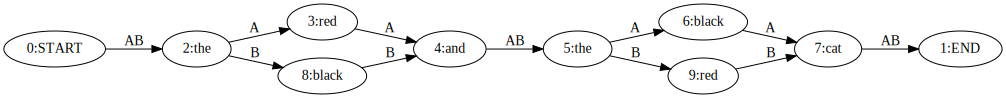

In [45]:
a = graphviz.Digraph(format="svg")
a.graph_attr['rankdir'] = 'LR'
for item in variant_graph.nodes: # set of Node objects, call it "item" to avoid overusing the keyword "node"
    if item.id == 0:
        ngram = 'START'
    elif item.id== 1:
        ngram = 'END'
    elif 'A' in item.token_positions:
        ngram = witnesses[0][item.token_positions['A']]
    elif 'B' in item.token_positions:
        ngram = witnesses[1][item.token_positions['B']]
    else:
        ngram = 'ERROR'
    a.node(str(item.id), label=str(item.id) + ':' + ngram)
for item in variant_graph.edges:
    outgoing_edge_targets = variant_graph_adjacency_list[item.source]
    if len(outgoing_edge_targets) == 1: # if there is one edge, get its label from its source
        label = "".join(variant_graph.nodes[item.source].token_positions.keys())
    else: # there are two edges, so two possible cases
        outgoing_edge_target_counts = sum([len(variant_graph_node_by_id[target_node].token_positions) for target_node in variant_graph_adjacency_list[item.source]]) # 2 in simple case, 3 in dificult one
        if outgoing_edge_target_counts == 2: # easy case; each target has one witness
            label = "".join([k for k, v in variant_graph_node_by_id[item.target].token_positions.items()]) # ugly way to retrieve a single siglum
        else: # difficult case; one target has one witness and one has two; which is which?
            node_with_two_witnesses = outgoing_edge_targets[0] if len(variant_graph_node_by_id[outgoing_edge_targets[0]].token_positions) == 2 else outgoing_edge_targets[1]
            node_with_one_witness = outgoing_edge_targets[0] if len(variant_graph_node_by_id[outgoing_edge_targets[0]].token_positions) == 1 else outgoing_edge_targets[1]
            single_witness_label = [k for k,v in variant_graph_node_by_id[node_with_one_witness].token_positions.items()][0] # ugly way to get only key as string value
            difficult_label = ({'A', 'B'} - {single_witness_label})
            if item.target == node_with_two_witnesses:
                label = difficult_label.pop() # get the lone set member as a string
            else:
                label = single_witness_label
    a.edge(str(item.source), str(item.target), label=label)
SVG(a.view())

In [46]:
a.view()

'Digraph.gv.svg'

In [47]:
variant_graph.edges

[Variant_graph_edge(source=0, target=2),
 Variant_graph_edge(source=2, target=3),
 Variant_graph_edge(source=3, target=4),
 Variant_graph_edge(source=4, target=5),
 Variant_graph_edge(source=5, target=6),
 Variant_graph_edge(source=6, target=7),
 Variant_graph_edge(source=7, target=1),
 Variant_graph_edge(source=2, target=8),
 Variant_graph_edge(source=8, target=4),
 Variant_graph_edge(source=5, target=9),
 Variant_graph_edge(source=9, target=7)]

In [48]:
variant_graph_edge_target_by_source

{0: 2, 2: 8, 3: 4, 4: 5, 5: 9, 6: 7, 7: 1, 8: 4, 9: 7}